In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import pickle
import sys
import imp
sys.path.append('../')
%matplotlib inline

/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    MinLengthLogitsProcessor,
    LogitsProcessorList,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
from cvar_helpers import calc_cvar_from_quantiles
from cvar_sampler import distort_probabilities
from rl_learner import TD_Learner
from generate_sentences_w_cvar import score_sentiment

In [4]:
import manual_examples_sentences
imp.reload(manual_examples_sentences)
from manual_examples_sentences import (get_chain_distribution, 
                                       plot_distributions, 
                                       get_distributions, 
                                       get_probabilities)

### Loading Models

In [5]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)
model = GPT2LMHeadModel.from_pretrained(modelname)
device = 'cpu'

In [6]:
sentiment_tokenizer = AutoTokenizer.from_pretrained('../models/pretrained/cardiffnlp-twitter-roberta-base-sentiment')
sentiment_model = AutoModelForSequenceClassification.from_pretrained('../models/pretrained/cardiffnlp-twitter-roberta-base-sentiment')
sentiment_model.to(device);

In [7]:
entailment_classifier = pipeline("zero-shot-classification", 
                                 model='../models/pretrained/nli-distilroberta-base')

In [8]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alphas = np.append(np.insert(taus, 0, 0), 1) # add zero, one

In [9]:
def load_rl_model(epoch=48, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards',
                  folder = 'sentence_chains_I_4',huber=0.1):

    filename='../data/results/'+folder+'/'
    filename+=f'quantile_learner_{hidden_dim}_{huber}{extra}/log_quantile_learner_epoch{epoch}.pkl'

    Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
    Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))
    print(filename)
    log = pickle.load(open(filename,'rb'))
    loss = np.array(log['loss'])
    epoch = np.array(log['epoch'])
    
    taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
    
    out = {'Z_network': Z_network,
             'loss': loss,
           'taus' : taus,
          'log':log,
          'epoch':epoch}
    return(out)

### Testing the quantile network

In [10]:
import manual_examples_sentences
imp.reload(manual_examples_sentences)
from manual_examples_sentences import get_chain_distribution

#### Intermediate Rewards

In [11]:
# with prompt v3
epoch=48
hidden_dim =100
n_quantiles = 10
prompt_enc = '_nt_rewards'
filename=f'../data/results/sentence_chains_I_4/'

filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'
Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))


<All keys matched successfully>

[[-0.87 -0.52 -0.35 -0.22 -0.11  0.    0.12  0.24  0.4   0.71]
 [-1.   -0.68 -0.53 -0.41 -0.31 -0.21 -0.1   0.02  0.17  0.48]
 [-1.25 -0.92 -0.78 -0.67 -0.58 -0.48 -0.38 -0.27 -0.13  0.19]
 [-1.6  -1.23 -1.05 -0.91 -0.79 -0.68 -0.57 -0.44 -0.28  0.04]
 [-1.88 -1.6  -1.46 -1.36 -1.27 -1.19 -1.1  -1.02 -0.9  -0.67]]
[-0.80320371]


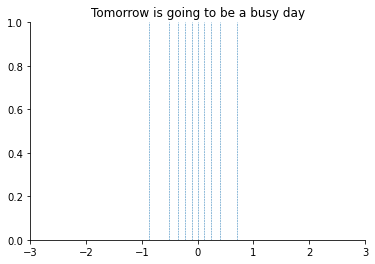

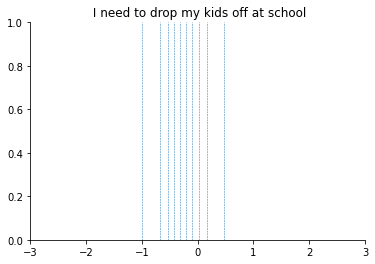

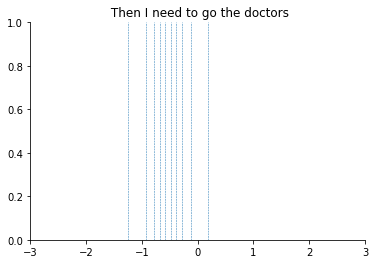

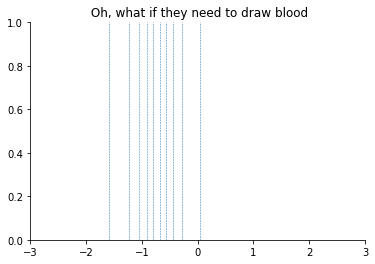

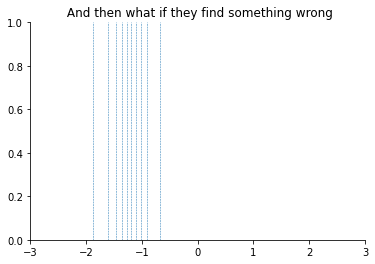

In [12]:
prompt = 'Tomorrow is going to be a busy day. I need to drop my kids off at school. Then I need to go the doctors. '+\
         'Oh, what if they need to draw blood. '+\
         'And then what if they find something wrong.'

sentences = prompt.split('.')
thetas, cvars = get_chain_distribution(prompt, tokenizer, model, device, Z_network)
print(np.round(thetas,2))
for i in range(thetas.shape[0]):
    plt.figure()
    plt.title(sentences[i])
    for j in range(thetas.shape[1]):
        plt.axvline(x=thetas[i,j], linestyle='--', linewidth=0.5)
        sns.despine()
        plt.xlim([-3,3])

print(score_sentiment(prompt, sentiment_tokenizer, sentiment_model, device))

#### Terminal Rewards

In [13]:
# with prompt v3
epoch=48
hidden_dim =100
n_quantiles = 10
prompt_enc = ''
filename=f'../data/results/sentence_chains_I_4/'

filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'
Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))


<All keys matched successfully>

[[ 0.53  0.67  0.76  0.84  0.92  1.    1.06  1.15  1.29  1.56]
 [-1.12 -0.86 -0.7  -0.57 -0.46 -0.36 -0.24 -0.11  0.08  0.46]
 [-1.02 -0.73 -0.56 -0.43 -0.32 -0.22 -0.11  0.01  0.19  0.56]
 [-1.26 -1.06 -0.96 -0.87 -0.81 -0.75 -0.69 -0.62 -0.53 -0.33]]
[-0.8948153]


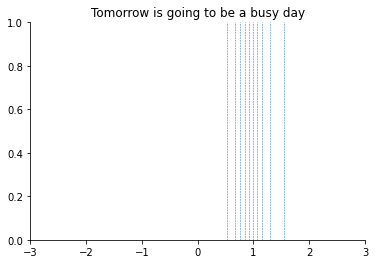

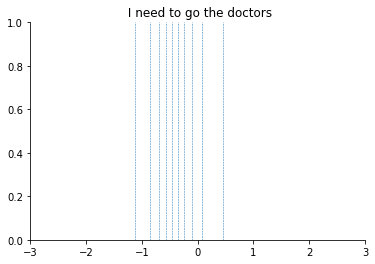

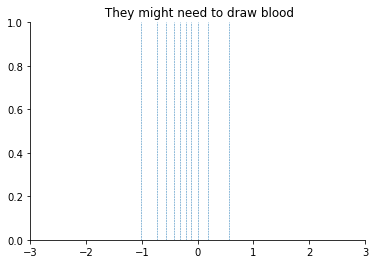

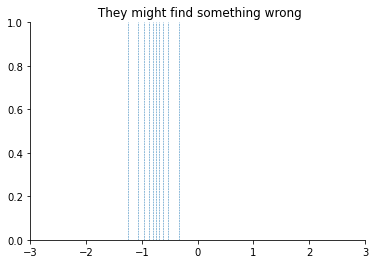

In [14]:
prompt = 'Tomorrow is going to be a busy day. I need to go the doctors. '+\
         'They might need to draw blood. '+\
         'They might find something wrong.'


sentences = prompt.split('.')
thetas, cvars = get_chain_distribution(prompt, tokenizer, model, device, Z_network)
print(np.round(thetas,2))
for i in range(thetas.shape[0]):
    plt.figure()
    plt.title(sentences[i])
    for j in range(thetas.shape[1]):
        plt.axvline(x=thetas[i,j], linestyle='--', linewidth=0.5)
        sns.despine()
        plt.xlim([-3,3])

print(score_sentiment(prompt, sentiment_tokenizer, sentiment_model, device))

[[ 0.53  0.67  0.76  0.84  0.92  1.    1.06  1.15  1.29  1.56]
 [-1.12 -0.86 -0.7  -0.57 -0.46 -0.36 -0.24 -0.11  0.08  0.46]
 [-1.74 -1.39 -1.19 -1.04 -0.9  -0.77 -0.65 -0.52 -0.31  0.11]
 [-1.62 -1.36 -1.21 -1.1  -1.01 -0.92 -0.84 -0.74 -0.62 -0.34]]
[-0.81884369]


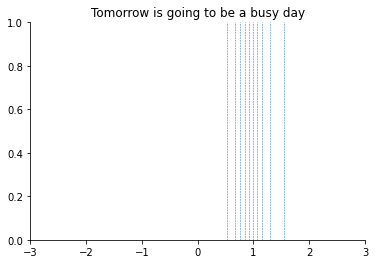

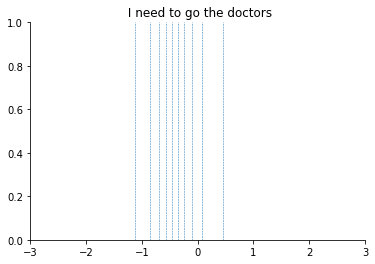

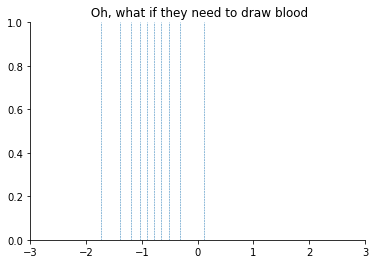

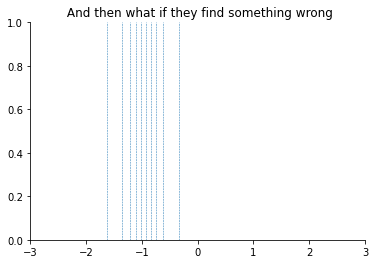

In [15]:
prompt = 'Tomorrow is going to be a busy day. I need to go the doctors. '+\
         'Oh, what if they need to draw blood. '+\
         'And then what if they find something wrong.'

sentences = prompt.split('.')
thetas, cvars = get_chain_distribution(prompt, tokenizer, model, device, Z_network)
print(np.round(thetas,2))
for i in range(thetas.shape[0]):
    plt.figure()
    plt.title(sentences[i])
    for j in range(thetas.shape[1]):
        plt.axvline(x=thetas[i,j], linestyle='--', linewidth=0.5)
        sns.despine()
        plt.xlim([-3,3])

print(score_sentiment(prompt, sentiment_tokenizer, sentiment_model, device))

[[ 0.53  0.67  0.76  0.84  0.92  1.    1.06  1.15  1.29  1.56]
 [-0.9  -0.65 -0.5  -0.38 -0.27 -0.17 -0.06  0.07  0.24  0.6 ]
 [-0.75 -0.47 -0.31 -0.18 -0.06  0.05  0.16  0.29  0.48  0.86]
 [ 0.18  0.5   0.68  0.83  0.96  1.09  1.22  1.38  1.59  2.01]]
[0.8602699]


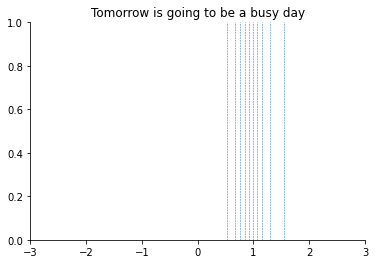

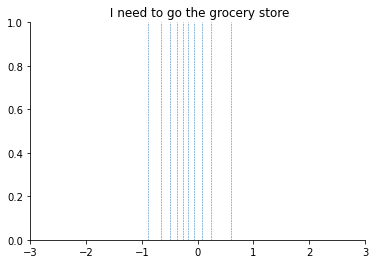

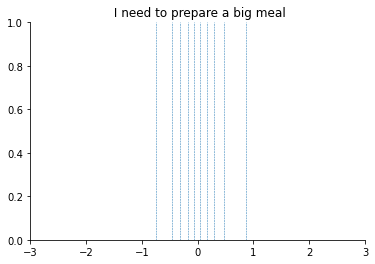

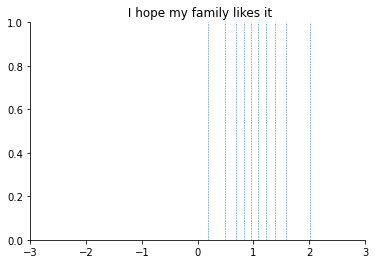

In [16]:
prompt = 'Tomorrow is going to be a busy day. I need to go the grocery store. '+\
         'I need to prepare a big meal. '+\
         'I hope my family likes it.'

sentences = prompt.split('.')
thetas, cvars = get_chain_distribution(prompt, tokenizer, model, device, Z_network)
print(np.round(thetas,2))
for i in range(thetas.shape[0]):
    plt.figure()
    plt.title(sentences[i])
    for j in range(thetas.shape[1]):
        plt.axvline(x=thetas[i,j], linestyle='--', linewidth=0.5)
        sns.despine()
        plt.xlim([-3,3])

print(score_sentiment(prompt, sentiment_tokenizer, sentiment_model, device))

[[ 0.53  0.67  0.76  0.84  0.92  1.    1.06  1.15  1.29  1.56]
 [-0.44 -0.21 -0.06  0.06  0.17  0.27  0.37  0.5   0.67  1.01]
 [-0.38 -0.14  0.    0.12  0.21  0.31  0.4   0.52  0.67  0.98]
 [ 0.37  0.69  0.86  1.01  1.14  1.27  1.41  1.56  1.77  2.2 ]]
[0.90110084]


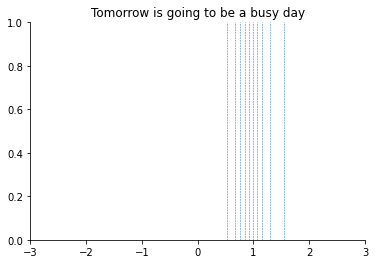

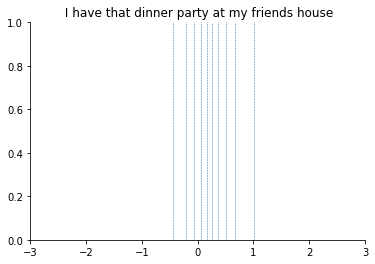

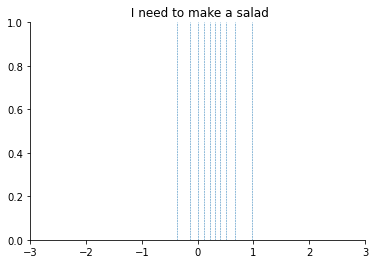

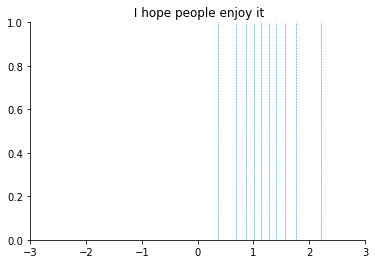

In [17]:
prompt = 'Tomorrow is going to be a busy day. I have that dinner party at my friends house. '+\
         'I need to make a salad. '+\
         'I hope people enjoy it.'

sentences = prompt.split('.')
thetas, cvars = get_chain_distribution(prompt, tokenizer, model, device, Z_network)
print(np.round(thetas,2))
for i in range(thetas.shape[0]):
    plt.figure()
    plt.title(sentences[i])
    for j in range(thetas.shape[1]):
        plt.axvline(x=thetas[i,j], linestyle='--', linewidth=0.5)
        sns.despine()
        plt.xlim([-3,3])

print(score_sentiment(prompt, sentiment_tokenizer, sentiment_model, device))

### Doctors, Friends, Gocery Store (non-terminal)(single plot)

In [ ]:
epoch=48
hidden_dim =100
n_quantiles = 10
prompt_enc = '_nt_rewards'
filename=f'../data/results/sentence_chains_I_4/'

filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'
Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))



In [ ]:
import manual_examples_sentences
imp.reload(manual_examples_sentences)
from manual_examples_sentences import (get_chain_distribution, 
                                       plot_distributions, 
                                       get_distributions, 
                                       get_probabilities)

#### full plot

In [ ]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        'Finally, they had an opening.',
                        "It's quite far away."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']

num_options = 3
scaler = 1
height=2.6*scaler
#width = 3.5*scaler
width = 4.3*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    
    # add space in front
    next_sent = ' '+next_sent
    allowed_next = [' '+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-2,2]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=True, include_quantiles=True, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent
plt.subplots_adjust(wspace=1.4)

#### non-distorted

In [ ]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        'Finally, they had an opening.',
                        "It's quite far away."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']


num_options = 3
scaler = 1
height=2.6*scaler
#width = 3.5*scaler
width = 4.3*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    
    # add space in front
    next_sent = ' '+next_sent
    allowed_next = [' '+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-2,2]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=False, include_quantiles=True, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent
plt.subplots_adjust(wspace=1.4)

#### words only

In [ ]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        'Finally, they had an opening.',
                        "It's quite far away."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']
num_options = 3
scaler = 1
height=2.6*scaler
#width = 3.5*scaler
width = 4.3*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    
    # add space in front
    next_sent = ' '+next_sent
    allowed_next = [' '+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-2,2]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=False, include_quantiles=False, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent
plt.subplots_adjust(wspace=1.4)

### (Using) Doctors, Friends, Gocery Store (composite rewards)(single plot)(better examples)

In [18]:
out = load_rl_model(epoch=48, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards',
                          folder = 'sentence_chains_I_5',huber=0.1)
Z_network = out['Z_network']

out = load_rl_model(epoch=48, hidden_dim =10, n_quantiles = 10, extra = '_composite_rewards',
                          folder = 'sentence_chains_I_5',huber=0.1)
Z_network = out['Z_network']

../data/results/sentence_chains_I_5/quantile_learner_100_0.1_composite_rewards/log_quantile_learner_epoch48.pkl
../data/results/sentence_chains_I_5/quantile_learner_10_0.1_composite_rewards/log_quantile_learner_epoch48.pkl


In [32]:
import manual_examples_sentences
imp.reload(manual_examples_sentences)
from manual_examples_sentences import (get_chain_distribution, 
                                       plot_distributions, 
                                       get_distributions, 
                                       get_probabilities)

#### full plot

Tomorrow will be a busy day.
[" I will attend my friend's party.", ' I need to go to the grocery store.', " I need to go to the doctor's."]
[0.35 0.34 0.31]
[0.   0.17 0.83]
 I need to go to the doctor's.
0.2670477413501852

Tomorrow will be a busy day. I need to go to the doctor's.
[' They might need to draw some blood.', " I'm glad they had an opening.", " It's quite far away."]
[0.51 0.4  0.09]
[0.84 0.08 0.08]
 They might need to draw some blood.
0.44000967724133694

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood.
[' They could find something wrong with me.', ' Cool, they can check my cholesterol.', " I'll need to make sure to eat afterwards."]
[0.7  0.16 0.14]
[0.9  0.02 0.08]
 They could find something wrong with me.
0.5666313339870299

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood. They could find something wrong with me.
[' Then I might be sick for a long time.', " But then I'll recov

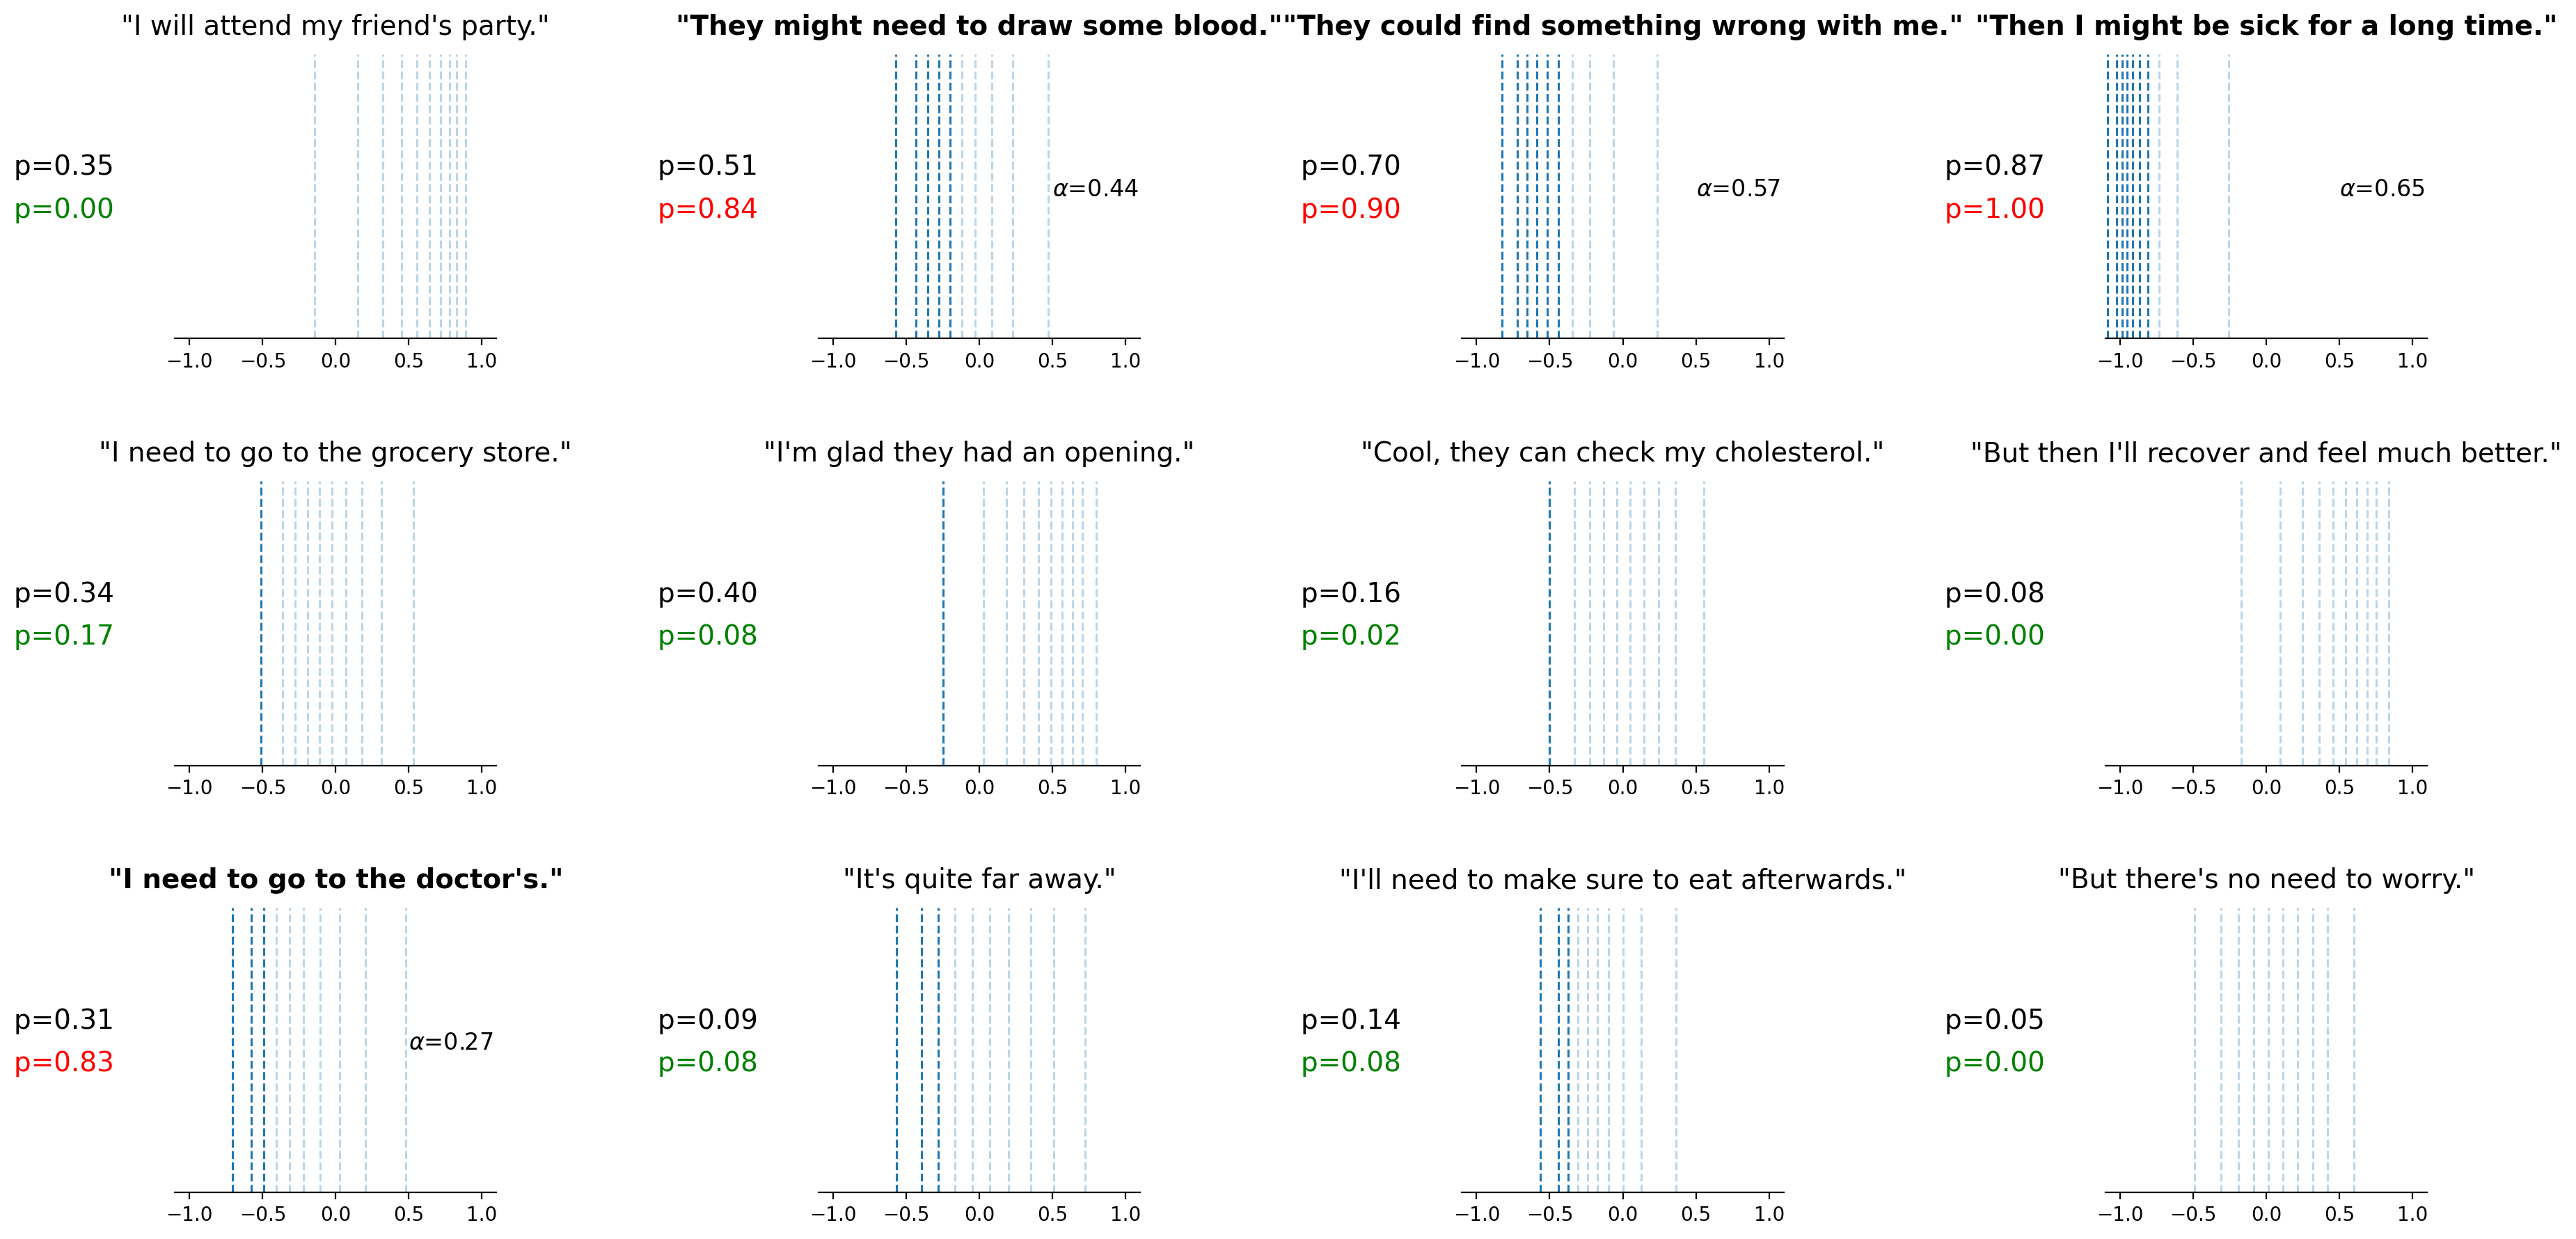

In [33]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
# this is highly negative 
#  "I don't know what's wrong with me."

allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        "I'm glad they had an opening.",
                        "It's quite far away."],
                          
#                        ['They might need to draw some blood.', 
#                         "And then I'll see you at home.",
#                         "I don't know what's wrong with me."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']


num_options = 3
scaler = 1
# height=2.6*scaler
# #width = 3.5*scaler
width = 4.5*scaler
height=3*scaler
#width = 3.5*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    

    # add space in front
    next_sent = " "+next_sent
    allowed_next = [" "+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    #if i==1:
    #    import ipdb; ipdb.set_trace()
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    

    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-1.1,1.1]
    next_alpha_tmp = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=True, include_quantiles=True, include_distribution=False,
                      next_alpha=next_alpha_tmp)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

#### non-distorted

Tomorrow will be a busy day.
[" I will attend my friend's party.", ' I need to go to the grocery store.', " I need to go to the doctor's."]
[0.35 0.34 0.31]
[0.   0.17 0.83]
 I need to go to the doctor's.
0.2670472811510485

Tomorrow will be a busy day. I need to go to the doctor's.
[' They might need to draw some blood.', " I'm glad they had an opening.", " It's quite far away."]
[0.51 0.4  0.09]
[0.84 0.07 0.08]
 They might need to draw some blood.
0.4409600024120933

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood.
[' They could find something wrong with me.', ' Cool, they can check my cholesterol.', " I'll need to make sure to eat afterwards."]
[0.7  0.16 0.14]
[0.9  0.02 0.08]
 They could find something wrong with me.
0.5679182595140426

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood. They could find something wrong with me.
[' Then I might be sick for a long time.', " But then I'll recove

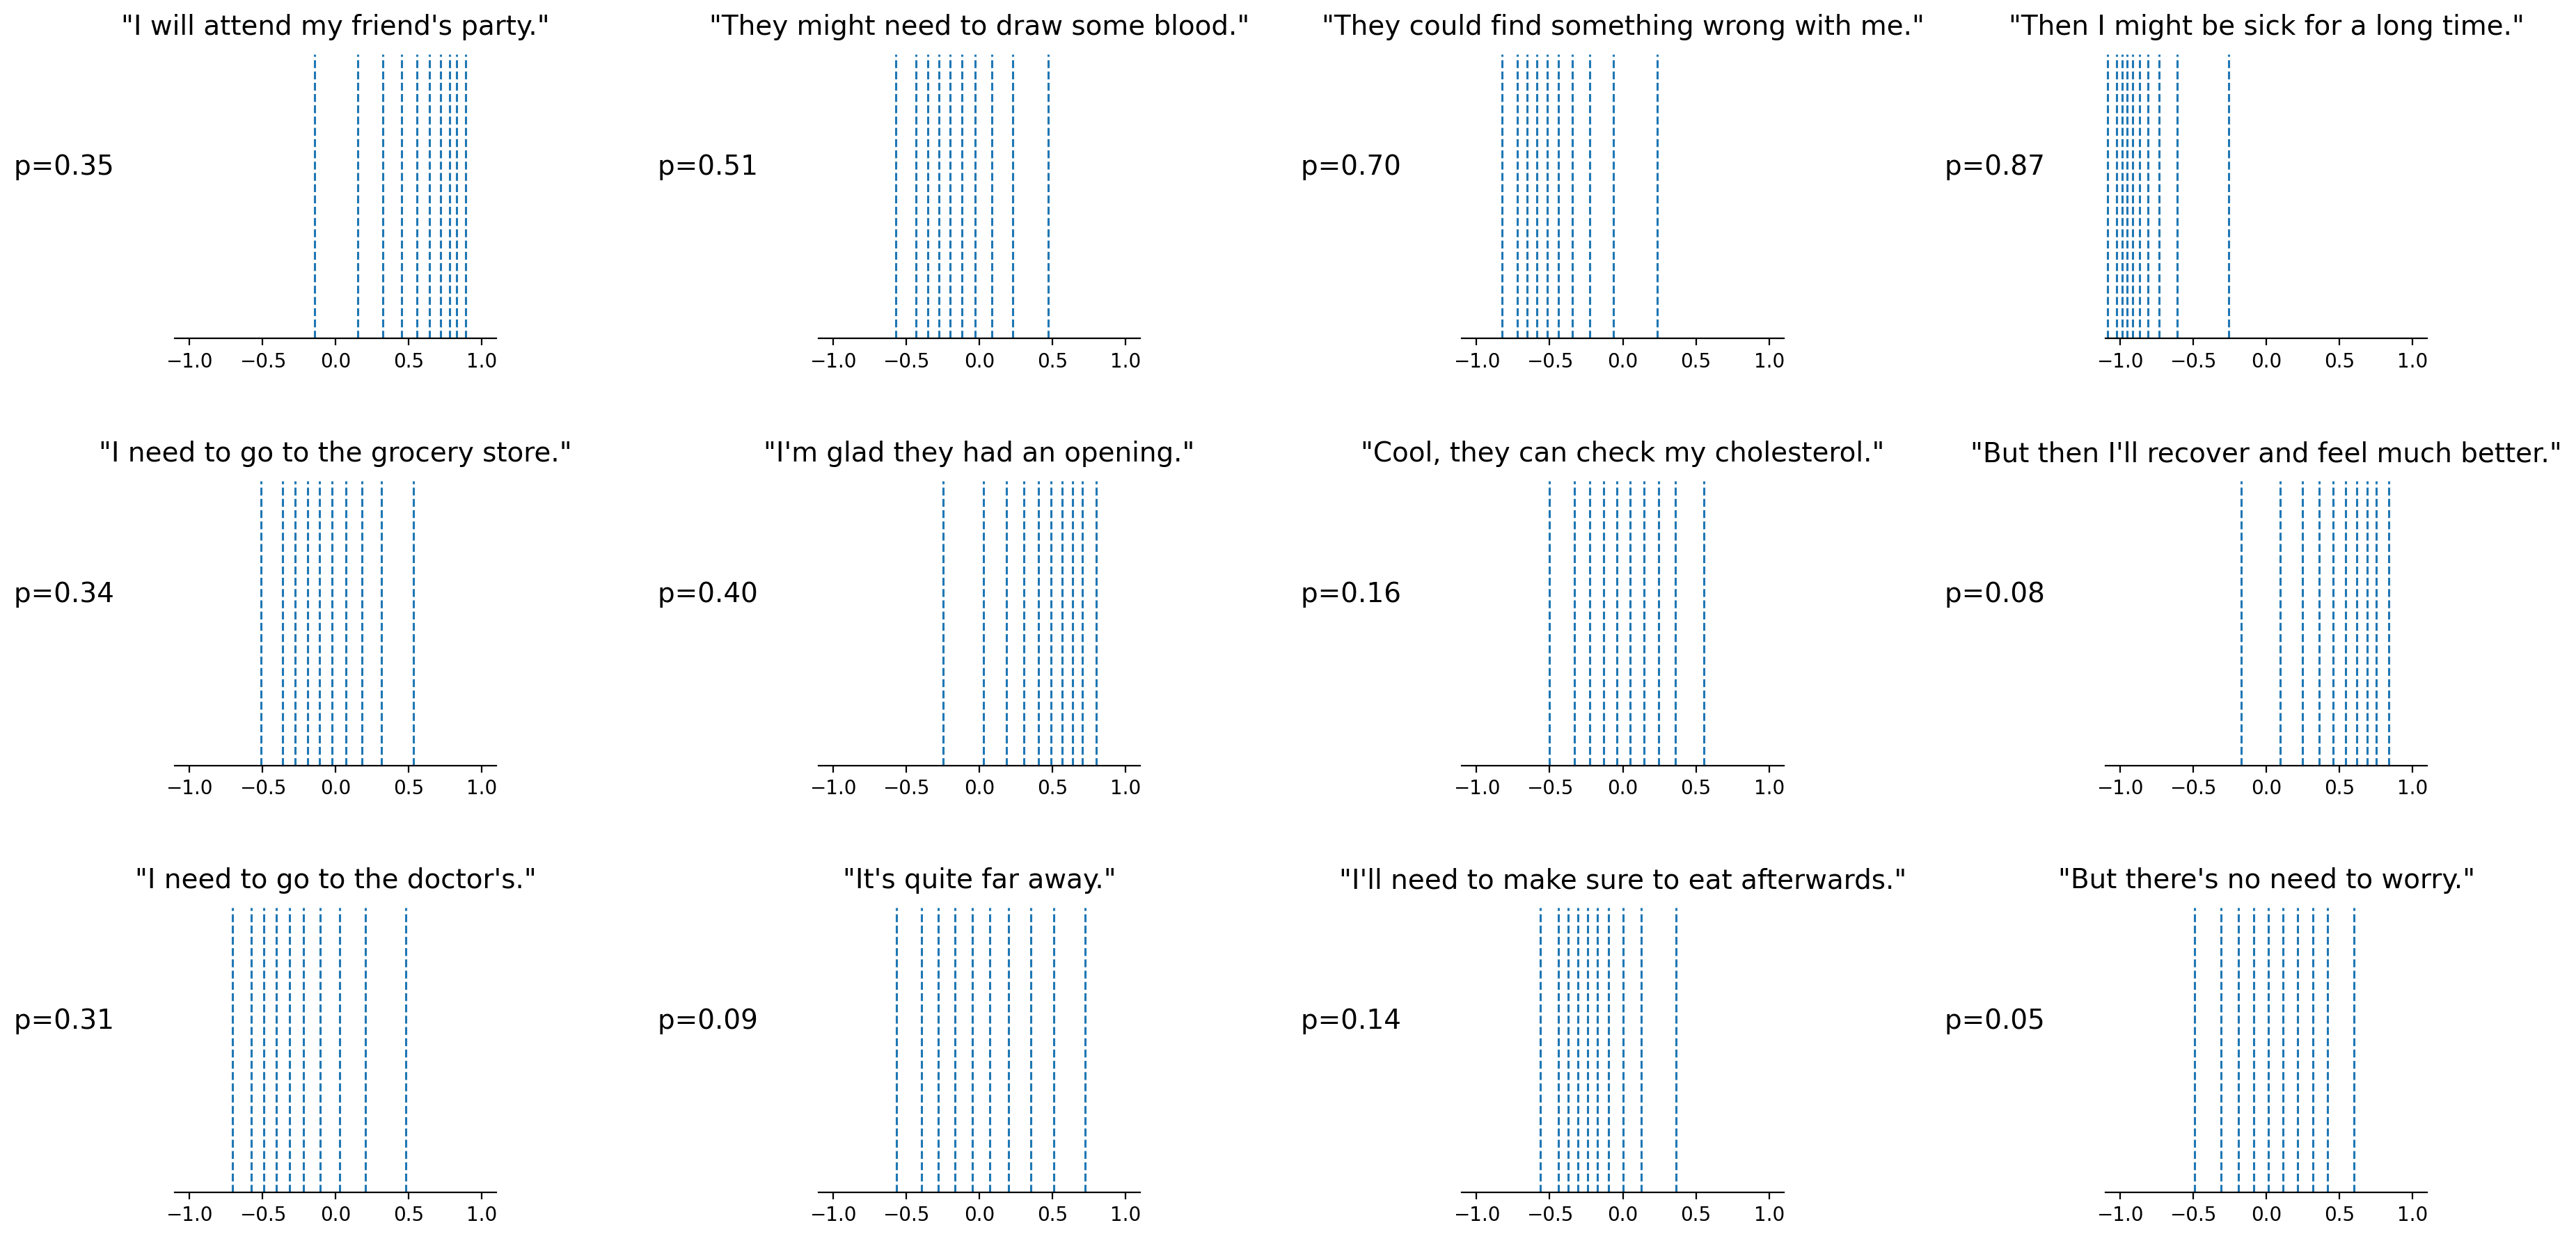

In [12]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
# this is highly negative 
#  "I don't know what's wrong with me."

allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        "I'm glad they had an opening.",
                        "It's quite far away."],
                          
#                        ['They might need to draw some blood.', 
#                         "And then I'll see you at home.",
#                         "I don't know what's wrong with me."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']


num_options = 3
scaler = 1
# height=2.6*scaler
# #width = 3.5*scaler
width = 4.5*scaler
height=3*scaler
#width = 3.5*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    

    # add space in front
    next_sent = " "+next_sent
    allowed_next = [" "+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    #if i==1:
    #    import ipdb; ipdb.set_trace()
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    

    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-1.1,1.1]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=False, include_quantiles=True, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

#### words only

Tomorrow will be a busy day.
[" I will attend my friend's party.", ' I need to go to the grocery store.', " I need to go to the doctor's."]
[0.35 0.34 0.31]
[0.   0.17 0.83]
 I need to go to the doctor's.
0.2670457395878936

Tomorrow will be a busy day. I need to go to the doctor's.
[' They might need to draw some blood.', " I'm glad they had an opening.", " It's quite far away."]
[0.51 0.4  0.09]
[0.84 0.08 0.08]
 They might need to draw some blood.
0.44026013879964315

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood.
[' They could find something wrong with me.', ' Cool, they can check my cholesterol.', " I'll need to make sure to eat afterwards."]
[0.7  0.16 0.14]
[0.9  0.02 0.08]
 They could find something wrong with me.
0.5668121829919609

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood. They could find something wrong with me.
[' Then I might be sick for a long time.', " But then I'll recov

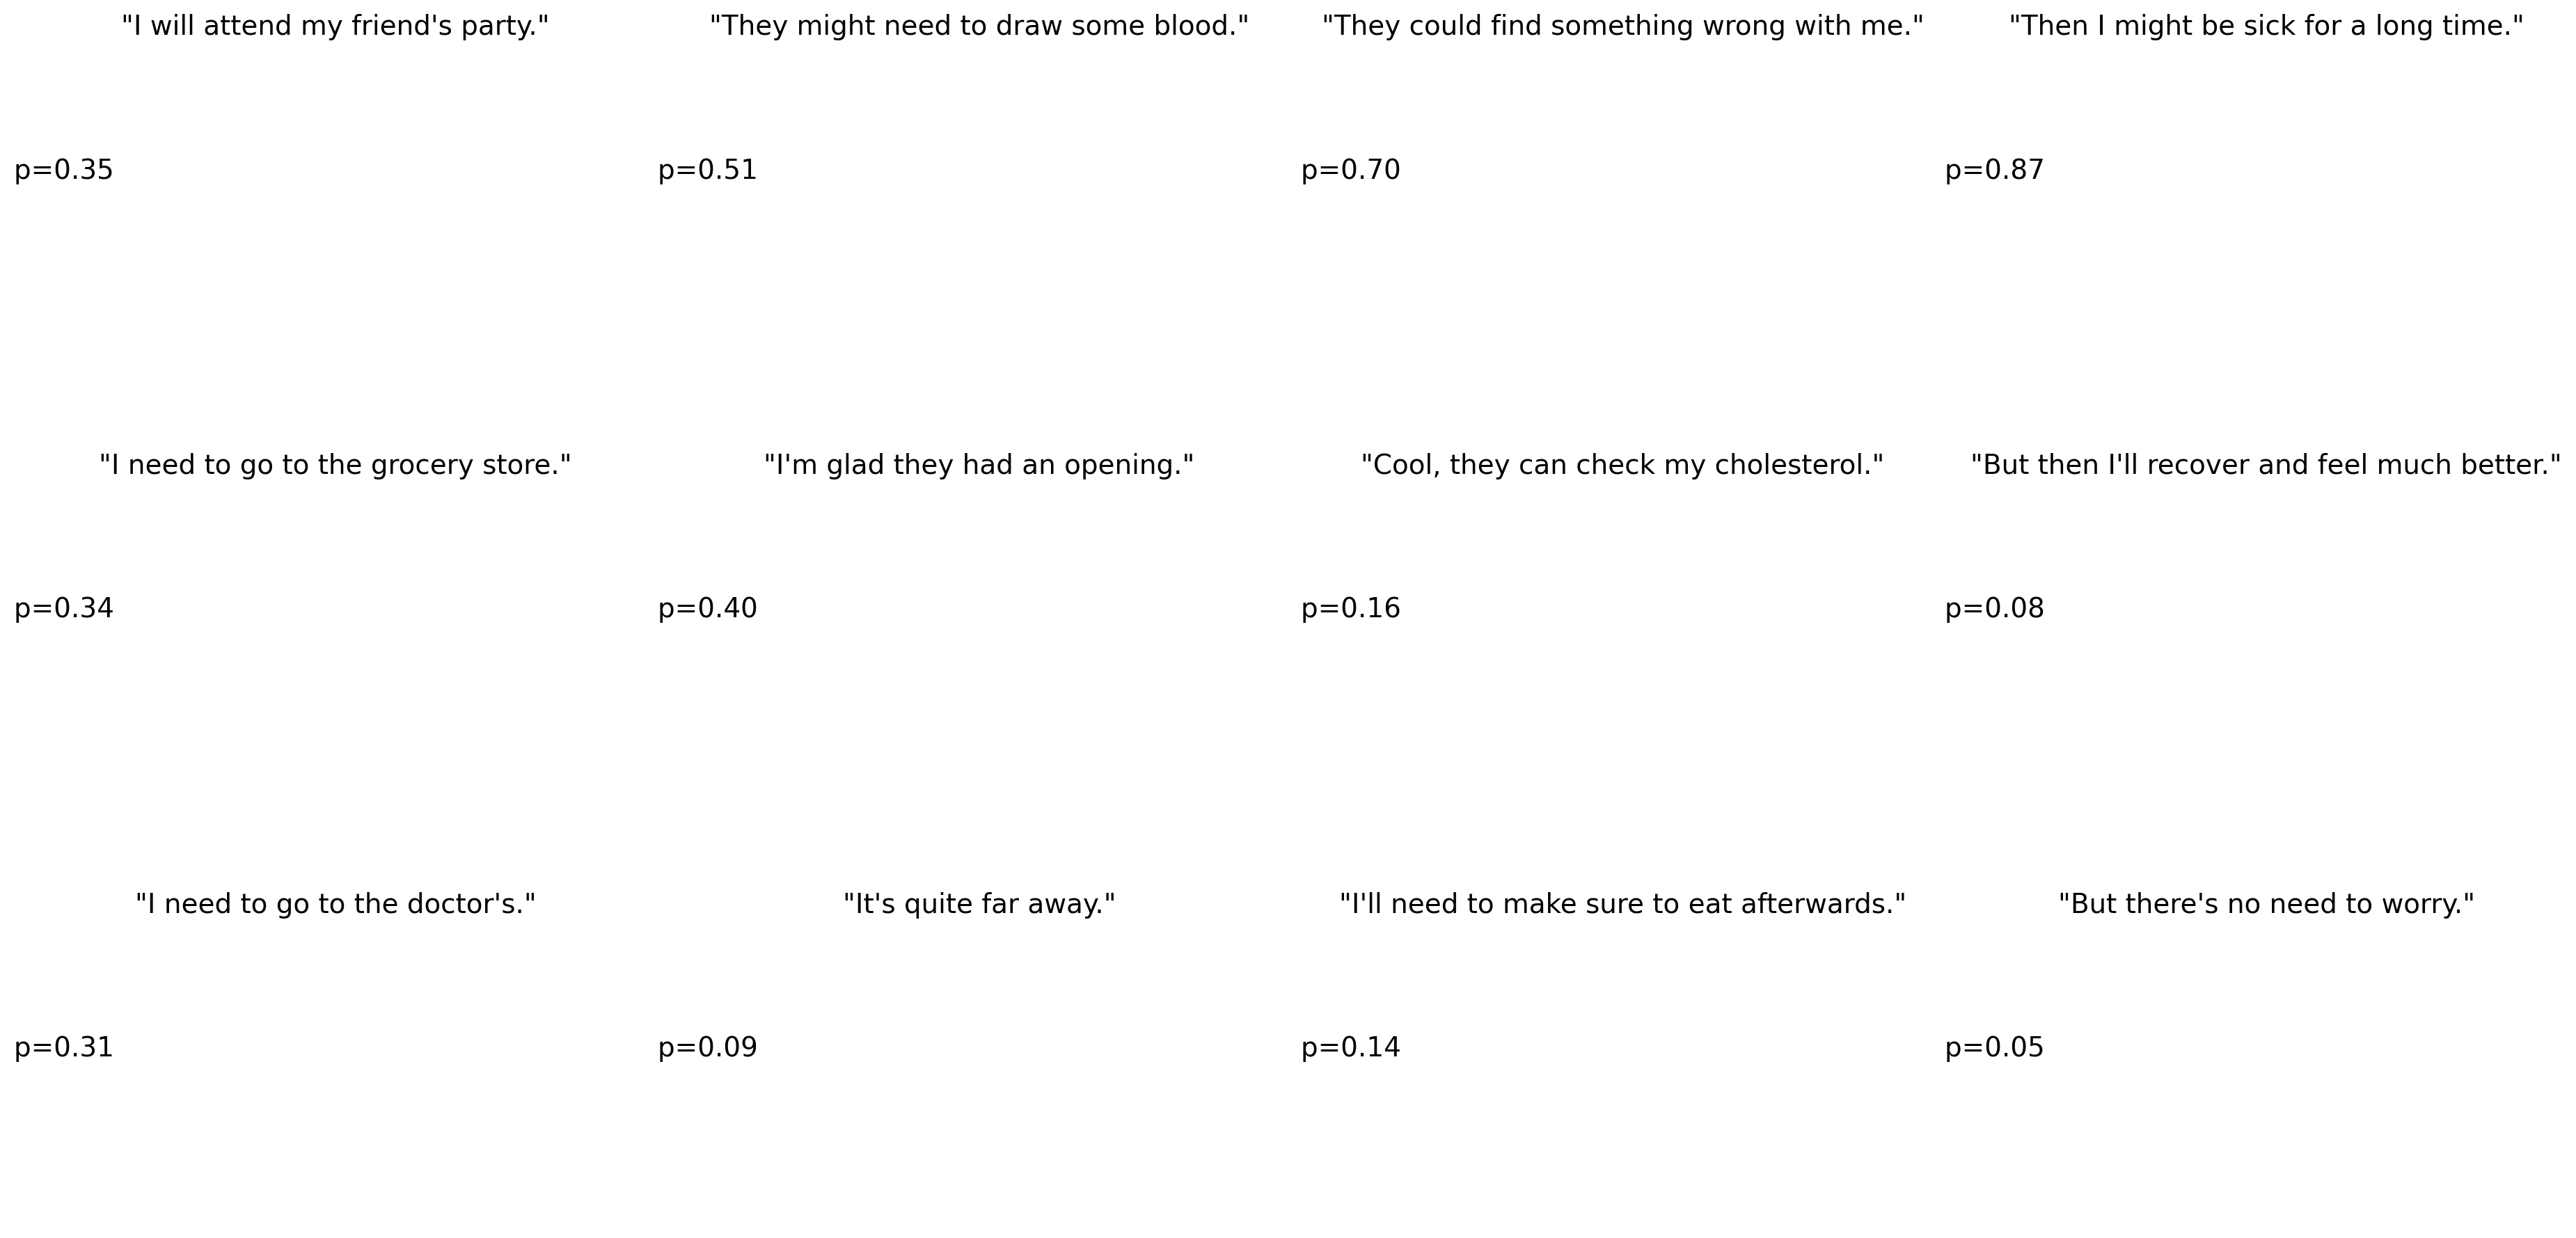

In [13]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
# this is highly negative 
#  "I don't know what's wrong with me."

allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        "I'm glad they had an opening.",
                        "It's quite far away."],
                          
#                        ['They might need to draw some blood.', 
#                         "And then I'll see you at home.",
#                         "I don't know what's wrong with me."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']


num_options = 3
scaler = 1
# height=2.6*scaler
# #width = 3.5*scaler
width = 4.5*scaler
height=3*scaler
#width = 3.5*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    

    # add space in front
    next_sent = " "+next_sent
    allowed_next = [" "+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    #if i==1:
    #    import ipdb; ipdb.set_trace()
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    

    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-1.1,1.1]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=False, include_quantiles=False, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

### Doctors, Friends, Gocery Store (composite rewards)(single plot)(better examples) (100 hidden unit different dataset -- NOT AS GOOD

In [16]:
out = load_rl_model(epoch=98, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards_2',
                          folder = 'sentence_chains_I_5',huber=0.1)
Z_network = out['Z_network']

# out = load_rl_model(epoch=98, hidden_dim =10, n_quantiles = 10, extra = '_composite_rewards_2',
#                           folder = 'sentence_chains_I_5',huber=0.1)
# Z_network = out['Z_network']

../data/results/sentence_chains_I_5/quantile_learner_100_0.1_composite_rewards_2/log_quantile_learner_epoch98.pkl


In [17]:
import manual_examples_sentences
imp.reload(manual_examples_sentences)
from manual_examples_sentences import (get_chain_distribution, 
                                       plot_distributions, 
                                       get_distributions, 
                                       get_probabilities)

#### full plot

Tomorrow will be a busy day.
[" I will attend my friend's party.", ' I need to go to the grocery store.', " I need to go to the doctor's."]
[0.35 0.34 0.31]
[0.   0.17 0.83]
 I need to go to the doctor's.
0.26704999672442015

Tomorrow will be a busy day. I need to go to the doctor's.
[' They might need to draw some blood.', " I'm glad they had an opening.", " It's quite far away."]
[0.51 0.4  0.09]
[0.86 0.08 0.06]
 They might need to draw some blood.
0.4499219525497511

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood.
[' They could find something wrong with me.', ' Cool, they can check my cholesterol.', " I'll need to make sure to eat afterwards."]
[0.7  0.16 0.14]
[0.98 0.02 0.  ]
 They could find something wrong with me.
0.6309228520962579

Tomorrow will be a busy day. I need to go to the doctor's. They might need to draw some blood. They could find something wrong with me.
[' Then I might be sick for a long time.', " But then I'll recov

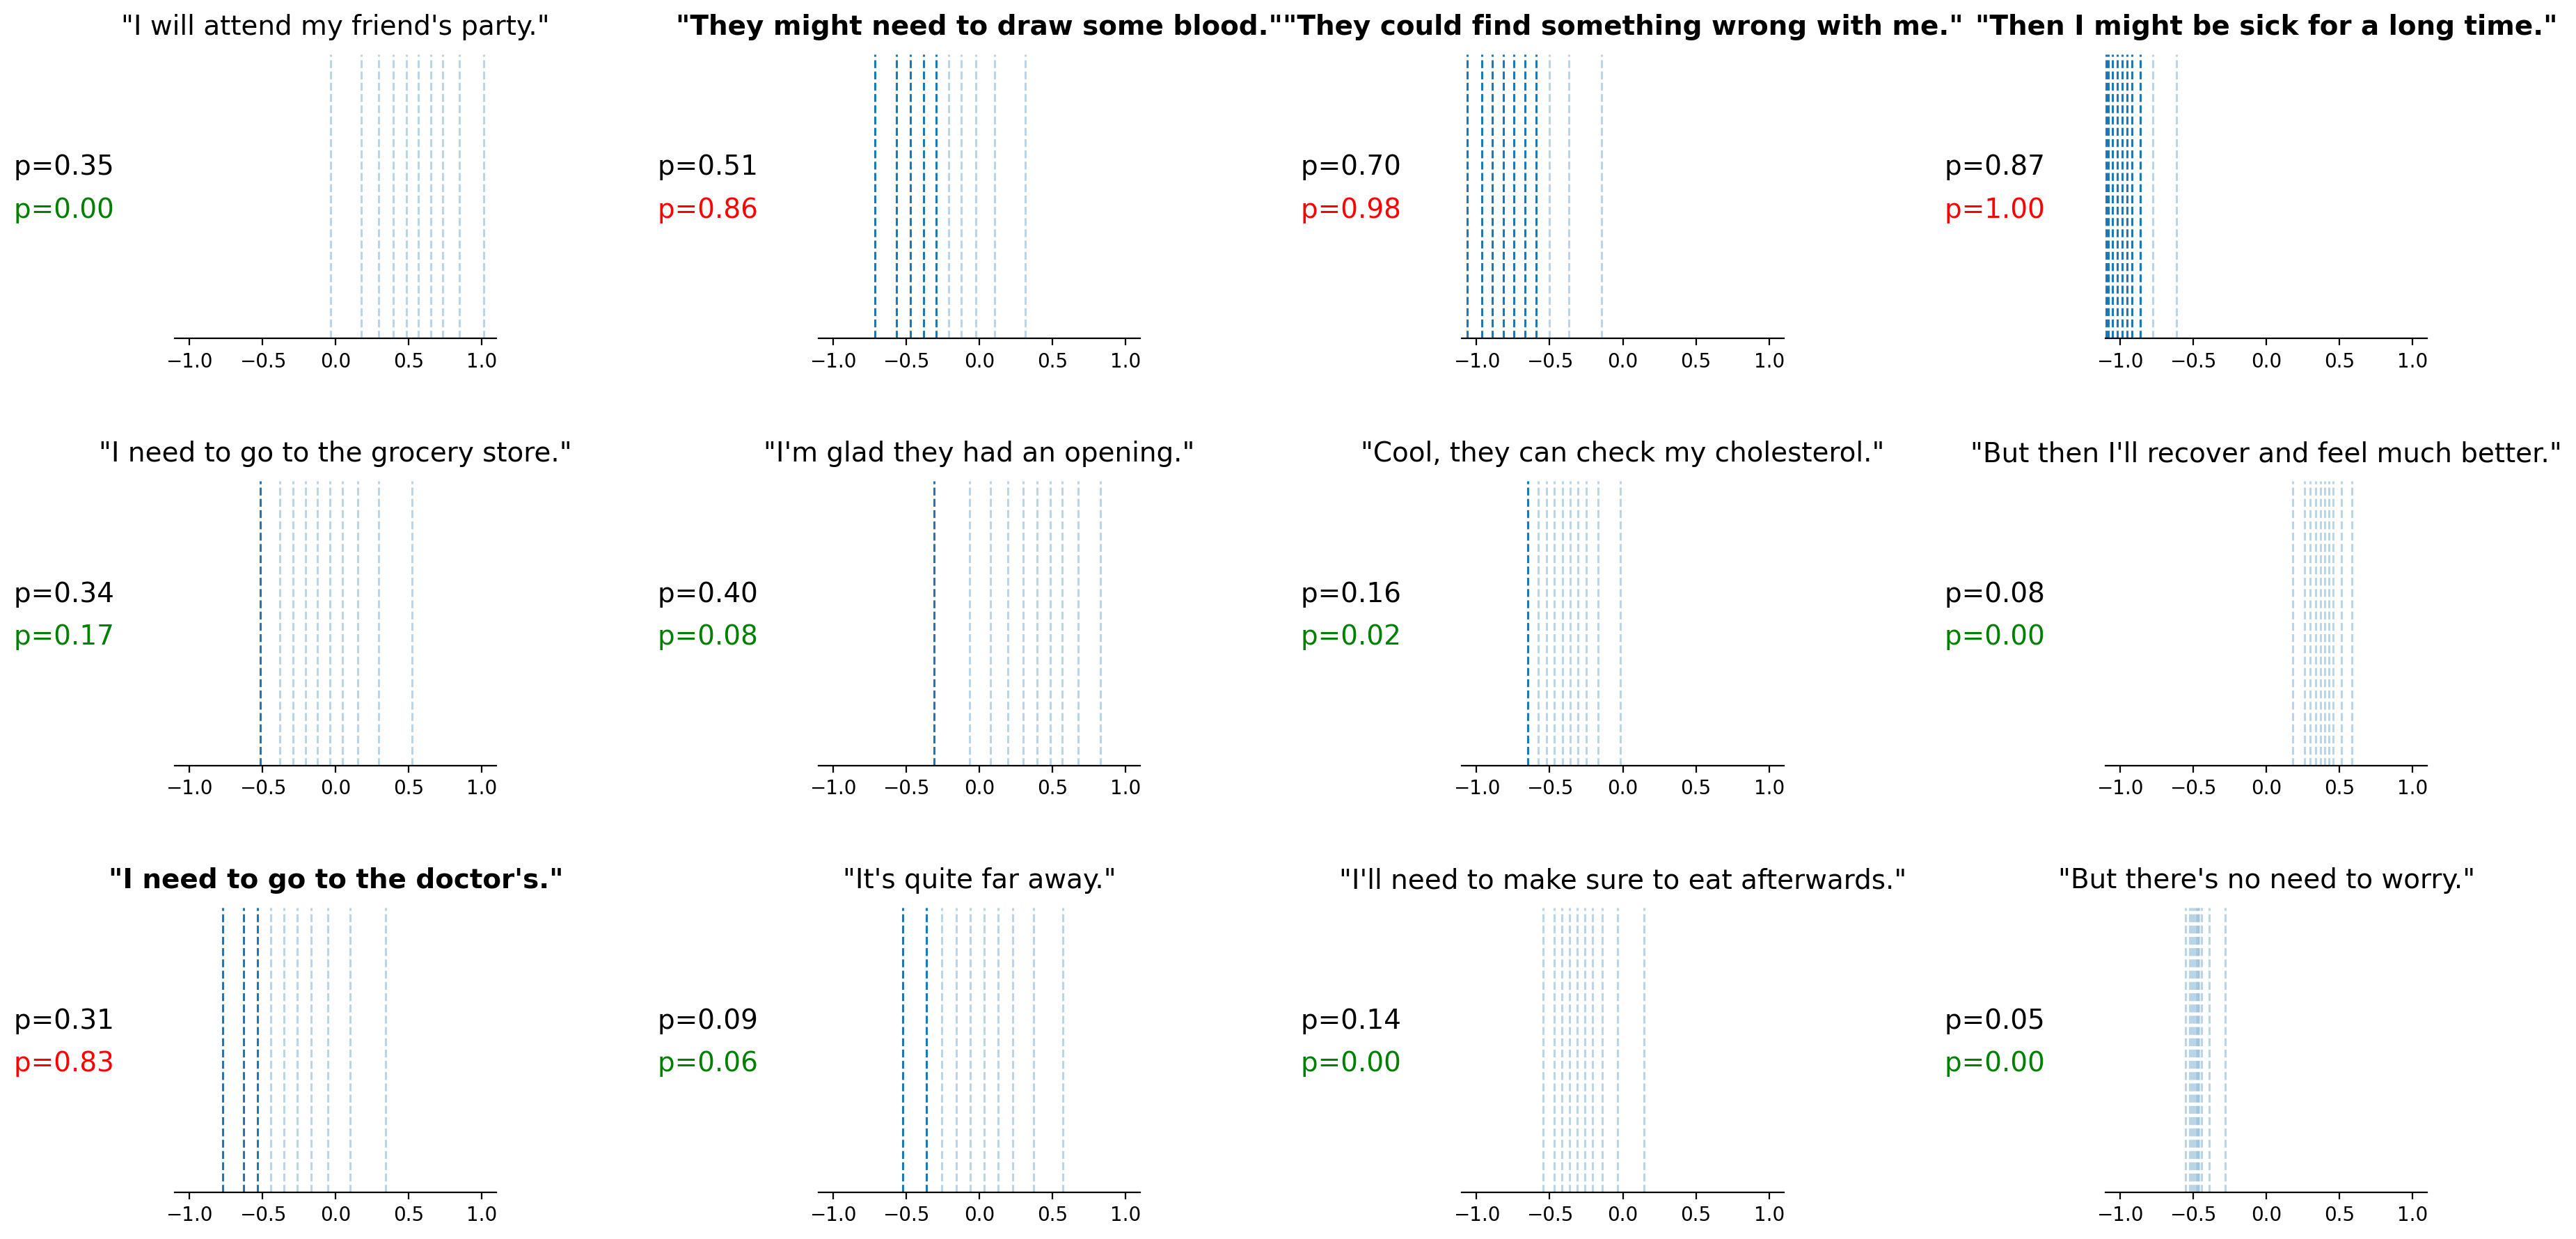

In [18]:
chain = 'Tomorrow will be a busy day.'
#chain = 'Tomorrow will be a difficult day.'
# this is highly negative 
#  "I don't know what's wrong with me."

allowed_next_sentences = [["I will attend my friend's party.", 
                           "I need to go to the grocery store.", 
                           "I need to go to the doctor's."],
                          
                          
                       ['They might need to draw some blood.', 
                        "I'm glad they had an opening.",
                        "It's quite far away."],
                          
#                        ['They might need to draw some blood.', 
#                         "And then I'll see you at home.",
#                         "I don't know what's wrong with me."],
                          
                       ['They could find something wrong with me.',
                        'Cool, they can check my cholesterol.',
                        "I'll need to make sure to eat afterwards."],

                        ["Then I might be sick for a long time.",
                        "But then I'll recover and feel much better.",
                        "But there's no need to worry."],
                           ]

cvar_alpha = 0.1
next_sentences=["I need to go to the doctor's." ,
                'They might need to draw some blood.', 
                'They could find something wrong with me.',
                'Then I might be sick for a long time.']


num_options = 3
scaler = 1
# height=2.6*scaler
# #width = 3.5*scaler
width = 4.5*scaler
height=3*scaler
#width = 3.5*scaler

fig, axes = plt.subplots(num_options,
                         len(next_sentences), 
                         figsize=(width*len(next_sentences), height*num_options), 
                         dpi=200)

for i, (next_sent, allowed_next) in enumerate(zip(next_sentences, allowed_next_sentences)):
    

    # add space in front
    next_sent = " "+next_sent
    allowed_next = [" "+an for an in allowed_next]
        
    # calculate probs, distributions 
    probs  = get_probabilities(chain, allowed_next, entailment_classifier, verbose=True)
    
    #if i==1:
    #    import ipdb; ipdb.set_trace()
    
    Vp, Vp_quantiles = get_distributions(chain, allowed_next, tokenizer, model, device, Z_network)
    

    
    probs_distorted, xis, extra = distort_probabilities(probs, cvar_alpha, alphas, Vp)
        
    # plot 
    xlim = [-1.1,1.1]
    plot_distributions(allowed_next, Vp_quantiles, probs, probs_distorted, vert=False,
                       fig=fig, axes=axes[:,i], next_sent=next_sent, 
                      alpha=cvar_alpha, taus=taus, xis=xis,
                      fs_title=14, fs_probs=14, xlim=xlim,
                      include_distorted_p=True, include_quantiles=True, include_distribution=False)
    
    # adjust alpha 
    cvar_alpha = float(xis[np.array(allowed_next)==next_sent]*cvar_alpha)
    
    # print
    print(chain)
    print(allowed_next)
    print(np.round(probs,2))
    print(np.round(probs_distorted,2))
    print(next_sent)
    print(cvar_alpha)
    print('')

    chain+=next_sent

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)